In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor 
from sklearn.preprocessing import StandardScaler
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json


from utils.helper_functions import split_data
from utils.helper_functions import get_features_and_target

/home/sammibulin/miniforge3/envs/DL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))

/home/sammibulin/miniforge3/envs/DL/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
train_df, val_df, test_df = split_data(cancer_df)

In [5]:
train_df.loc[:, numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df.loc[:, numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df.loc[:, numeric_cols] = scaler.transform(test_df[numeric_cols])

In [6]:
X_train, y_train = get_features_and_target(train_df)
X_val, y_val = get_features_and_target(val_df)
X_test, y_test = get_features_and_target(test_df)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((558, 989), (558,), (186, 989), (186,), (187, 989), (187,))

In [7]:
def gbm_objective_pipeline_y_scale(trial):
    gbm_params = {
        "regressor__gbm__n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "regressor__gbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "regressor__gbm__max_depth": trial.suggest_int("max_depth", 10, 25),
        "regressor__gbm__min_samples_split": trial.suggest_int("min_samples_split", 4, 25),
        "regressor__gbm__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25),
        "regressor__gbm__subsample": trial.suggest_float("subsample", 0.75, 1.0),
        "regressor__gbm__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        # Add random_state to the inner GBM if needed
        "regressor__gbm__random_state": 29
    }

    # Create scaler and GBM
    y_scaler = StandardScaler()
    inner_gbm_regressor = GradientBoostingRegressor()

    # Inner pipeline with gbm
    inner_pipeline = Pipeline([
        ('gbm', inner_gbm_regressor)
    ])

    # This wraps the inner_pipeline and applies y_scaler to the target
    model = TransformedTargetRegressor(
        regressor=inner_pipeline,
        transformer=y_scaler
    )

    model.set_params(**gbm_params)

    model.fit(X_train, y_train) # Pass original X_train, y_train
    
    y_pred = model.predict(X_val) # Predictions are automatically inverse-transformed

    mse = mean_squared_error(y_val, y_pred)

    return mse

# Use Optuna for hyperparameter search
gbm_study = optuna.create_study(direction="minimize", study_name="GBM_Pipeline_ScaleY")
gbm_study.optimize(gbm_objective_pipeline_y_scale, n_trials=50, n_jobs=-1)


[I 2025-04-18 13:27:10,423] A new study created in memory with name: GBM_Pipeline_ScaleY
[I 2025-04-18 13:27:14,109] Trial 2 finished with value: 794.325077048792 and parameters: {'n_estimators': 150, 'learning_rate': 0.09, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.9910838878202429, 'max_features': 'sqrt'}. Best is trial 2 with value: 794.325077048792.
[I 2025-04-18 13:27:17,595] Trial 8 finished with value: 922.2657481599095 and parameters: {'n_estimators': 300, 'learning_rate': 0.25, 'max_depth': 17, 'min_samples_split': 21, 'min_samples_leaf': 18, 'subsample': 0.964842775706217, 'max_features': 'sqrt'}. Best is trial 2 with value: 794.325077048792.
[I 2025-04-18 13:27:18,714] Trial 10 finished with value: 904.6788915128006 and parameters: {'n_estimators': 350, 'learning_rate': 0.26, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 12, 'subsample': 0.8980958057478456, 'max_features': 'sqrt'}. Best is trial 2 with value: 794.32507704879

Best Hyperparameters found by Optuna:
{
    "n_estimators": 100,
    "learning_rate": 0.02,
    "max_depth": 25,
    "min_samples_split": 8,
    "min_samples_leaf": 1,
    "subsample": 0.7566995924638414,
    "max_features": "sqrt"
}
Retraining complete.

Making predictions on validation data (X_test)...

Final Model Performance on the Test Set:
  Mean Squared Error (MSE): 510.7629
  R-squared (R2):         -0.2165
  Mean Absolute Error (MAE):18.6682

Generating Actual vs. Predicted scatterplot...


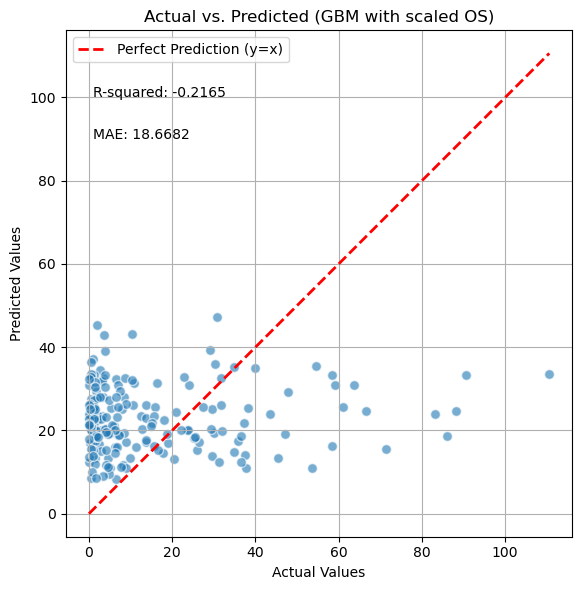

Plot displayed.


In [8]:
# 1. Get the Best Hyperparameters from Optuna
best_params = gbm_study.best_params 
print("Best Hyperparameters found by Optuna:")
print(json.dumps(best_params, indent=4))

# 2. Create the Final Model with the *SAME* Nested Structure
final_y_scaler = StandardScaler()
final_gbm = GradientBoostingRegressor(random_state=29) # Base instance

# Create the inner pipeline structure (ONLY GBM)
final_inner_pipeline = Pipeline([
    ('gbm', final_gbm)
])

# Create the outer TransformedTargetRegressor structure
final_model = TransformedTargetRegressor(
    regressor=final_inner_pipeline, # Wrap the simple pipeline
    transformer=final_y_scaler      # Use the y scaler
)


# Manually add prefixes to the parameters
best_params_prefixed = {}
for key, value in best_params.items():
    # Add the prefix needed for TransformedTargetRegressor -> Pipeline -> GBM
    new_key = f"regressor__gbm__{key}"
    best_params_prefixed[new_key] = value


with open("results/gbm_best_scaled_params.json", "w") as f:
    json.dump(best_params_prefixed, f, indent=4)


# Handles the nested 'regressor__gbm__...' parameters
final_model.set_params(**best_params_prefixed)

# fitting gbm on X_train and scaled_y_train
final_model.fit(X_train, y_train)
print("Retraining complete.")

# 5. Make Predictions on the Test Set
print(f"\nMaking predictions on validation data (X_test)...")
# Handles predicting scaled_y, and inverse-transforming y
y_pred_final = final_model.predict(X_test)
y_true_final = y_test

# 6. Evaluate the Final Model's Performance (on original y scale)
final_mse = mean_squared_error(y_true_final, y_pred_final)
final_r2 = r2_score(y_true_final, y_pred_final)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print("\nFinal Model Performance on the Test Set:")
print(f"  Mean Squared Error (MSE): {final_mse:.4f}")
print(f"  R-squared (R2):         {final_r2:.4f}")
print(f"  Mean Absolute Error (MAE):{final_mae:.4f}")

# 7. Create the Scatterplot (using original scale values)
print("\nGenerating Actual vs. Predicted scatterplot...")
plt.figure(figsize=(8, 6))
plt.scatter(y_true_final, y_pred_final, alpha=0.6, edgecolors='w', s=50)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (GBM with scaled OS)")

min_val = min(np.min(y_true_final), np.min(y_pred_final))
max_val = max(np.max(y_true_final), np.max(y_pred_final))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')


plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.text(1, 100, f"R-squared: {final_r2:.4f}")
plt.text(1, 90, f"MAE: {final_mae:.4f}")
plt.show()
print("Plot displayed.")

In [9]:
# Generate Regressor
gbm_reg = GradientBoostingRegressor(random_state = 29)

*Define Optuna Search Space*

In [10]:
def gbm_objective_no_scale(trial):
    gbm_params = {
        "gbm__n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "gbm__learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, step=0.01),
        "gbm__max_depth": trial.suggest_int("max_depth", 10, 25), # Your original depth range
        "gbm__min_samples_split": trial.suggest_int("min_samples_split", 4, 25), # Your original split range
        "gbm__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25), # Your original leaf range
        "gbm__subsample": trial.suggest_float("subsample", 0.75, 1.0), # Your original subsample range
        "gbm__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    }

    # Initiate the model
    gbm_pipeline = Pipeline([
        ('gbm', GradientBoostingRegressor(random_state=29))
    ])
    gbm_pipeline.set_params(**gbm_params)
    #GradientBoostingRegressor(random_state=29, **params)

    # Train the model
    gbm_pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = gbm_pipeline.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    return mse

*Run Optuna*

In [11]:
gbm_study = optuna.create_study(direction = "minimize", study_name = "GBM_Regressor")
gbm_study.optimize(gbm_objective_no_scale, n_trials = 50, n_jobs = -1)

# Save the best model
best_params = gbm_study.best_params
with open("results/gbm_best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

[I 2025-04-18 13:27:51,433] A new study created in memory with name: GBM_Regressor
[I 2025-04-18 13:27:53,539] Trial 1 finished with value: 780.2385900440829 and parameters: {'n_estimators': 100, 'learning_rate': 0.09999999999999999, 'max_depth': 21, 'min_samples_split': 21, 'min_samples_leaf': 15, 'subsample': 0.8725707687589676, 'max_features': 'sqrt'}. Best is trial 1 with value: 780.2385900440829.
[I 2025-04-18 13:27:54,497] Trial 7 finished with value: 864.0787176873415 and parameters: {'n_estimators': 150, 'learning_rate': 0.18000000000000002, 'max_depth': 14, 'min_samples_split': 23, 'min_samples_leaf': 19, 'subsample': 0.8697612776603487, 'max_features': 'log2'}. Best is trial 1 with value: 780.2385900440829.
[I 2025-04-18 13:27:55,197] Trial 3 finished with value: 887.6209886873568 and parameters: {'n_estimators': 200, 'learning_rate': 0.22, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 21, 'subsample': 0.8472421076190637, 'max_features': 'log2'}. Best is trial

In [12]:
best_params

{'n_estimators': 600,
 'learning_rate': 0.01,
 'max_depth': 23,
 'min_samples_split': 6,
 'min_samples_leaf': 17,
 'subsample': 0.9988883221493499,
 'max_features': 'sqrt'}

In [13]:
# Rename output keys to operate with sklearn pipeline
old_keys = list(best_params.keys())
for key in old_keys:
    new_key = "gbm__" + key
    best_params[new_key] = best_params.pop(key)

# Train the best model on the full training set
gbm_pipeline = Pipeline([
    ('gbm', GradientBoostingRegressor(random_state=29))
])
gbm_pipeline.set_params(**best_params)
gbm_pipeline.fit(X_train, y_train)


Pipeline(steps=[('gbm',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=23,
                                           max_features='sqrt',
                                           min_samples_leaf=17,
                                           min_samples_split=6,
                                           n_estimators=600, random_state=29,
                                           subsample=0.9988883221493499))])

In [14]:
# If using a separate test set, use X_test here
y_pred_final = gbm_pipeline.predict(X_test)
# Assign the corresponding true values
y_true_final = y_test # Or y_test

# 6. Evaluate the Final Model's Performance
final_mse = mean_squared_error(y_true_final, y_pred_final)
final_r2 = r2_score(y_true_final, y_pred_final)
final_mae = mean_absolute_error(y_true_final, y_pred_final)

print("\nFinal Model Performance on Validation/Test Set:")
print(f"  Mean Squared Error (MSE): {final_mse:.4f}")
print(f"  R-squared (R2):         {final_r2:.4f}")
print(f"  Mean Absolute Error (MAE):{final_mae:.4f}")


Final Model Performance on Validation/Test Set:
  Mean Squared Error (MSE): 507.5445
  R-squared (R2):         -0.2088
  Mean Absolute Error (MAE):18.0961


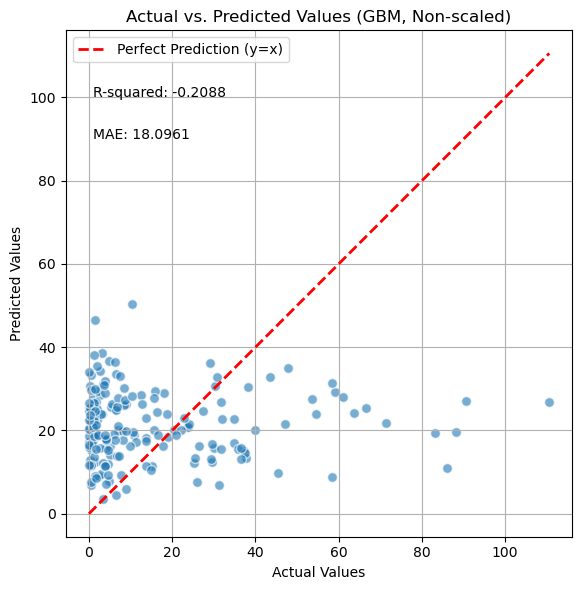

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true_final, y_pred_final, alpha=0.6, edgecolors='w', s=50) # Added some styling
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (GBM, Non-scaled)")

# Add a line for perfect correlation (y=x)
min_val = min(np.min(y_true_final), np.min(y_pred_final))
max_val = max(np.max(y_true_final), np.max(y_pred_final))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

plt.grid(True)
plt.legend()
# Ensure aspect ratio is equal if desired, helps visualize deviations from y=x
plt.gca().set_aspect('equal', adjustable='box')
plt.text(1, 100, f"R-squared: {final_r2:.4f}")
plt.text(1, 90, f"MAE: {final_mae:.4f}")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()